# **PROJECT 2: Xây dựng hệ thống nhận diện ngôn ngữ ký hiệu tay sử dụng học sâu**

Sinh viên thực hiện: Lê Đức Quân

#**1. Tải dữ liệu và nhập thư viện**

## **Tải dữ liệu**

In [ ]:
!gdown 1ezkXHiA8upwUlEM6EiQGj4VQJEvsUNLI
!unzip /content/ASL_alphabet.zip -d /content/dataset

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  infl

## **Nhập các thư viện cần thiết**

In [ ]:
import cv2
from glob import glob
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading inception v3 network for transfer learning
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split


# **2. Chuẩn bị và tiền xử lý dữ liệu**

## **Config**

In [ ]:
TRAINING_DIR = './data/asl_alphabet_train/asl_alphabet_train/'
TEST_DIR = './data/asl_alphabet_test/asl_alphabet_test/'
CLASSES = [folder[len(TRAINING_DIR):] for folder in glob(TRAINING_DIR + '/*')]
CLASSES.sort()

IMAGE_SIZE = 200
BATCH_SIZE = 64
N_CLASSES = 29
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1
MODEL_PATH = './model/cnn_asl_model.h5'

## **Data visualize**

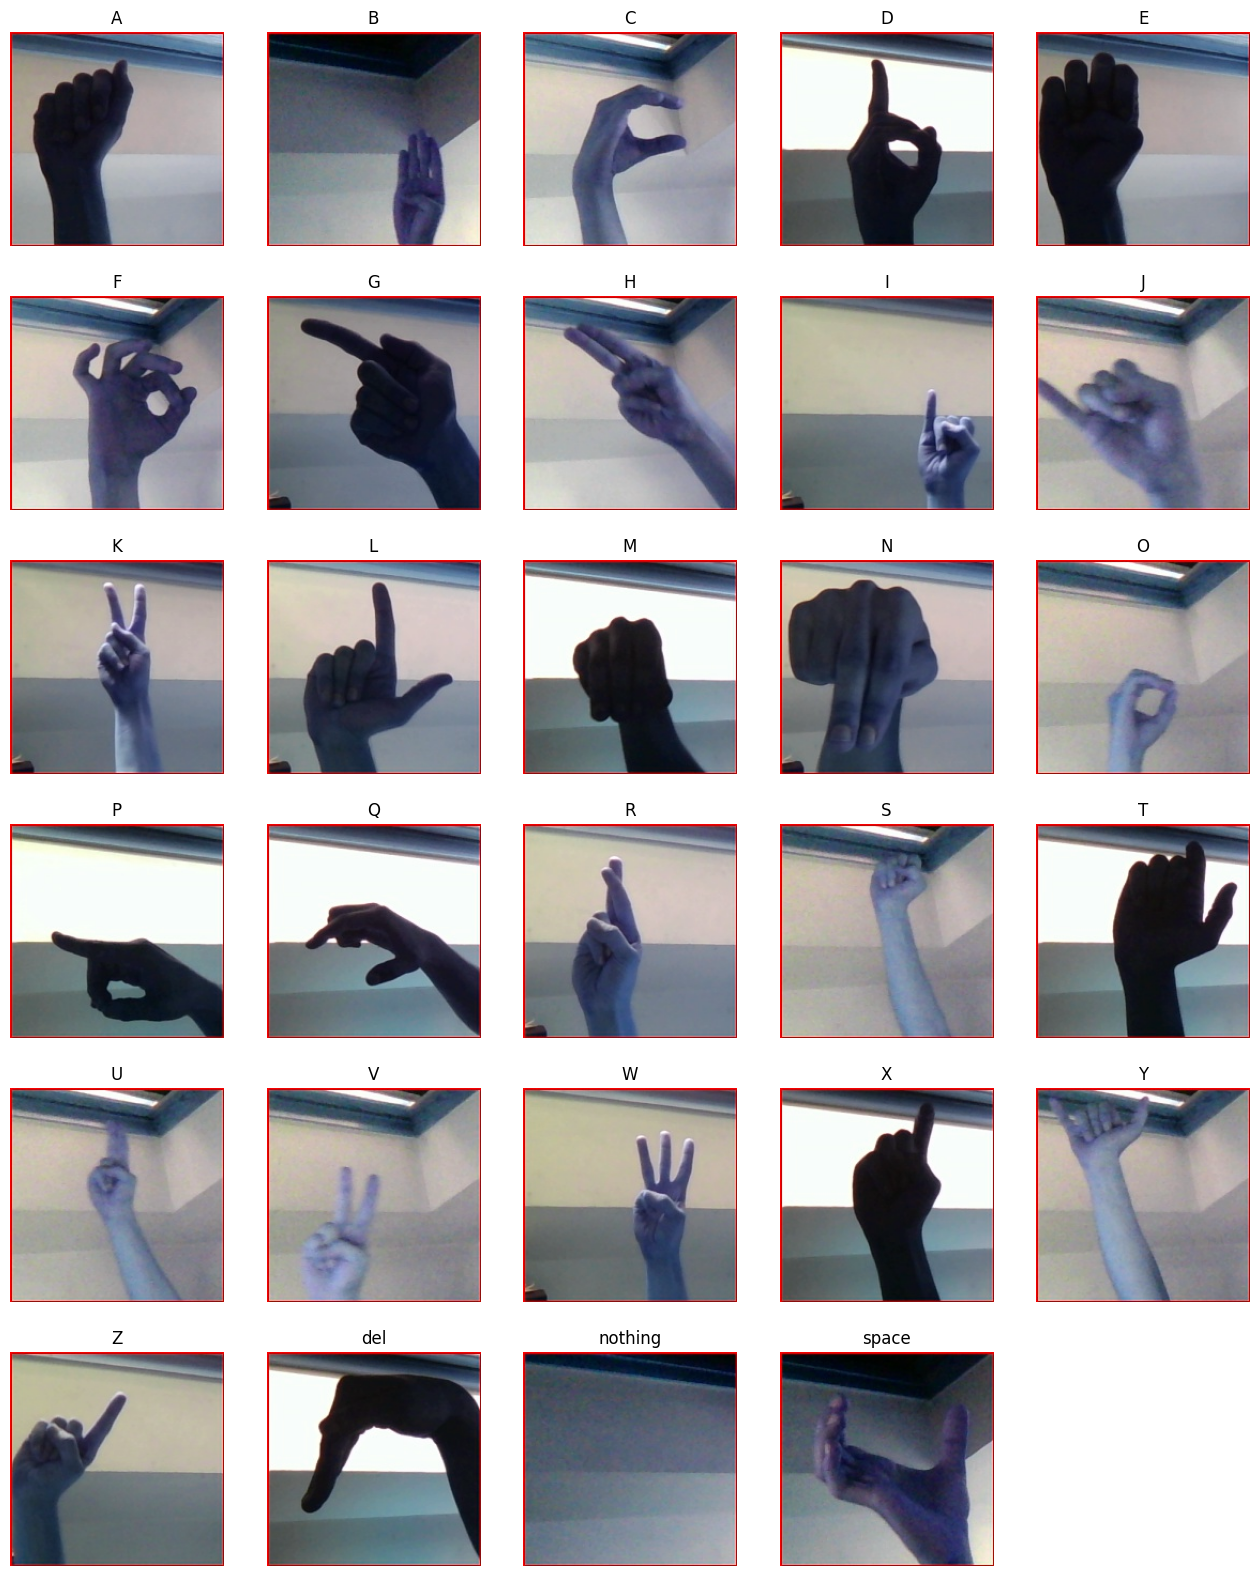

In [ ]:
%matplotlib inline

def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CLASSES) / cols))
    fig = plt.figure(figsize=(16, 20))

    for i in range(len(CLASSES)):
        cls = CLASSES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)

        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()

plot_one_sample_of_each(TRAINING_DIR)


## **Tiền xử lý dữ liệu**

In [ ]:
# Tạo Metadata lưu giữ thông tin về image_path và label
list_path = []
list_labels = []
for label in CLASSES:
    label_path = os.path.join(TRAINING_DIR, label, "*")
    image_files = glob(label_path)

    sign_label = [label] * len(image_files)

    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,./dataset/asl_alphabet_train/asl_alphabet_trai...,A
1,./dataset/asl_alphabet_train/asl_alphabet_trai...,A
2,./dataset/asl_alphabet_train/asl_alphabet_trai...,A
3,./dataset/asl_alphabet_train/asl_alphabet_trai...,A
4,./dataset/asl_alphabet_train/asl_alphabet_trai...,A
...,...,...
86995,./dataset/asl_alphabet_train/asl_alphabet_trai...,space
86996,./dataset/asl_alphabet_train/asl_alphabet_trai...,space
86997,./dataset/asl_alphabet_train/asl_alphabet_trai...,space
86998,./dataset/asl_alphabet_train/asl_alphabet_trai...,space


In [ ]:
# Tách thành 3 tập train, validation, test theo tỉ lệ như config

X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=TEST_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)

data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=VALIDATION_SIZE/TRAIN_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.,)

train_gen = ImageDataGenerator(
    rescale=1/255.,
    brightness_range=[0.8,1.2],
    zoom_range=[1.0,1.2],
    horizontal_flip=True)

train_generator = train_gen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

test_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=False
)

Found 48937 validated image filenames belonging to 29 classes.
Found 16313 validated image filenames belonging to 29 classes.
Found 16313 validated image filenames belonging to 29 classes.


# **3. Xây dựng mô hình**

## **Transfer learning using Inception V3 Network**

In [ ]:
base_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top = False,
    weights = 'imagenet'
)

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 1s 0us/step


## **Huấn luyện mô hình**

**Looking at the final model:**

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

**Setting up a callback funtion in order to stop training at a particular threshold:**

**Fit model :**

In [ ]:
train_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    # callbacks=[callback]
)

Epoch 1/10
765/765 [==============================] - 590s 751ms/step - loss: 0.5647 - accuracy: 0.8360 - val_loss: 0.4425 - val_accuracy: 0.8524
Epoch 2/10
765/765 [==============================] - 559s 731ms/step - loss: 0.2212 - accuracy: 0.9268 - val_loss: 0.3270 - val_accuracy: 0.8939
Epoch 3/10
765/765 [==============================] - 555s 726ms/step - loss: 0.1571 - accuracy: 0.9474 - val_loss: 0.3257 - val_accuracy: 0.8940
Epoch 4/10
765/765 [==============================] - 567s 742ms/step - loss: 0.1375 - accuracy: 0.9536 - val_loss: 0.2395 - val_accuracy: 0.9202
Epoch 5/10
765/765 [==============================] - 571s 746ms/step - loss: 0.1193 - accuracy: 0.9604 - val_loss: 0.2200 - val_accuracy: 0.9261
Epoch 6/10
765/765 [==============================] - 571s 746ms/step - loss: 0.1081 - accuracy: 0.9638 - val_loss: 0.1806 - val_accuracy: 0.9397
Epoch 7/10
765/765 [==============================] - 564s 737ms/step - loss: 0.1019 - accuracy: 0.9657 - val_loss: 0.3680 -

## **Fine-Tuning**

In [ ]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    # callbacks=[callback]
)

Epoch 1/5
765/765 [==============================] - 576s 739ms/step - loss: 0.1505 - accuracy: 0.9546 - val_loss: 0.0690 - val_accuracy: 0.9783
Epoch 2/5
765/765 [==============================] - 576s 753ms/step - loss: 0.0243 - accuracy: 0.9919 - val_loss: 0.0400 - val_accuracy: 0.9868
Epoch 3/5
765/765 [==============================] - 573s 749ms/step - loss: 0.0116 - accuracy: 0.9961 - val_loss: 0.0311 - val_accuracy: 0.9899
Epoch 4/5
765/765 [==============================] - 569s 744ms/step - loss: 0.0120 - accuracy: 0.9962 - val_loss: 0.0239 - val_accuracy: 0.9930
Epoch 5/5
765/765 [==============================] - 560s 732ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.0190 - val_accuracy: 0.9947


## **Lưu mô hình**

**As we were satisfied with our results we save our model:**

In [ ]:
# Saving the model
model.save(MODEL_PATH)

# **4. Đánh giá mô hình**

## **Model Testing**

In [ ]:
predictions = model.predict(test_generator)
predictions = predictions.argmax(axis=1)
true_labels = test_generator.classes

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(predictions, true_labels)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", accuracy))

16313/16313 [==============================] - 183s 11ms/step
Evaluate Test Accuracy: 0.99%


## **Training Loss and Metrics**

In [ ]:
def visualize_train_val(history):
  # Visualize Training and Validation Results
  fig = make_subplots(
          rows=1, cols=2,
          subplot_titles=["Model Loss", "Model Accuracy"],
  )

  # Configuration Plot
  class PlotCFG:
      marker_size = 8
      line_size = 2
      train_color = "#76503d"
      valid_color = "#deb392"


  # Loss Plot
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(loss)+1), y=loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Loss"
      ), row=1, col=1
  )

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_loss)+1), y=val_loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Loss"
      ), row=1, col=1
  )



  # Accuracy Plot
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(acc)+1), y=acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Accuracy"
      ), row=1, col=2
  )
  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_acc)+1), y=val_acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Accuracy"
      ), row=1, col=2
  )

  # Update Axes
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
  fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)


  # Update Layout
  fig.update_layout(
      title="Training Loss and Metrics", title_x=0.5,
      width=950, height=400,
      showlegend=False,
      plot_bgcolor="White",
      paper_bgcolor="White"
  )

  # Show
  fig.show(iframe_connected=True)


In [ ]:
visualize_train_val(train_history)

### Fine-tune

In [ ]:
visualize_train_val(fine_tune_history)

## **Confusion Matrix**

In [ ]:
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions,
        num_classes=29)

In [ ]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=CLASSES,
        y=CLASSES,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

## **Kiểm tra ảnh trên thực tế**

In [ ]:
# download self test, classes
!gdown 1cBKU4hs15XqA_Gheh9Acaxuie69nnnwy
!gdown 12ES0wAtwtEE8LOBq4KszOsnuseVyf6A_
!unzip /content/self_test.zip -d /content/

Downloading...
From: https://drive.google.com/uc?id=1cBKU4hs15XqA_Gheh9Acaxuie69nnnwy
To: /content/self_test.zip
100% 10.9M/10.9M [00:00<00:00, 184MB/s]
Downloading...
From: https://drive.google.com/uc?id=12ES0wAtwtEE8LOBq4KszOsnuseVyf6A_
To: /content/classes.txt
100% 69.0/69.0 [00:00<00:00, 332kB/s]
Archive:  /content/self_test.zip
  inflating: /content/self_test/A.png  
  inflating: /content/self_test/B.png  
  inflating: /content/self_test/C.png  
  inflating: /content/self_test/D.png  
  inflating: /content/self_test/E.png  
  inflating: /content/self_test/F.png  
  inflating: /content/self_test/G.png  
  inflating: /content/self_test/H.png  
  inflating: /content/self_test/I.png  
  inflating: /content/self_test/J.png  
  inflating: /content/self_test/K.png  
  inflating: /content/self_test/L.png  
  inflating: /content/self_test/M.png  
  inflating: /content/self_test/N.png  
  inflating: /content/self_test/nothing.png  
  inflating: /content/self_test/O.png  
  inflating: /conte

1/1 [==============================] - 1s 1s/step
space


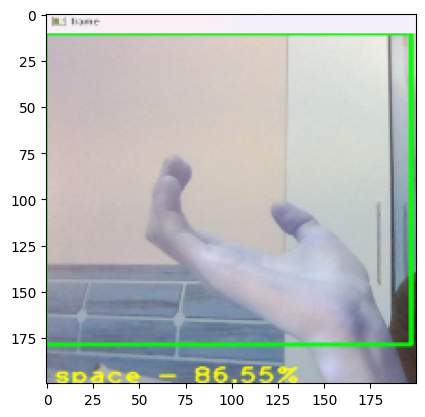

In [ ]:
image_location = './self_test/space.png'

# Creating list of available classes stored in classes.txt.
classes_file = open("classes.txt")
classes_string = classes_file.readline()
classes = classes_string.split()
classes.sort()  # The predict function sends out output in sorted order.

IMAGE_SIZE = 200

    img = cv2.imread(image_location)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = np.array(img) / 255.
plt.imshow(img)
img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))

prediction = np.array(model.predict(img))
predicted = classes[prediction.argmax()]

print(predicted)